<a href="https://colab.research.google.com/github/tushar-semwal/fedperf/blob/main/Vineeth/FedAvg_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
%%capture output
try:
    from google.colab import drive
    drive.mount('/content/drive')

    import os
    path = '/content/drive/MyDrive/Colab Notebooks/OpenMined/'
    os.makedirs(path, exist_ok=True)
except:
    path = './'

## Imports

In [22]:
%load_ext tensorboard
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils, datasets
from torchsummary import summary
from sklearn.metrics import f1_score

# Check assigned GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# set manual seed for reproducibility
seed = 42

# general reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Mon Apr 26 09:29:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    73W / 149W |   1276MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------

## Load the CIFAR Dataset

In [23]:
# create transforms
# We will just convert to tensor and normalize since no special transforms are mentioned in the paper
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

cifar_data_train = datasets.CIFAR10('../data/cifar10/', train=True, download=True, transform=transform_train)
cifar_data_test = datasets.CIFAR10('../data/cifar10/', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [24]:
classes = np.array(list(cifar_data_train.class_to_idx.values()))
classes_test = np.array(list(cifar_data_test.class_to_idx.values()))
num_classes = len(classes_test)
print("Classes: {} \tType: {}".format(classes, type(classes)))
print("Classes Test: {} \tType: {}".format(classes_test, type(classes)))


Classes: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>
Classes Test: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>


In [25]:
print("Image Shape: {}".format(cifar_data_train.data[0].shape))

Image Shape: (32, 32, 3)


## Visualize Data

In [26]:
def imshow(img):
	#img = img/2 + 0.5 #unnormalize the image
	plt.imshow(img, cmap='hsv') # convert from tensor to image

In [27]:
def visualize(dataset):
  figure = plt.figure(figsize=(25,4))
  for i in range(20):
    axis = figure.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    data = dataset.data[i]
    #data = data.numpy()

    target = dataset.targets[i]
    #target = target.numpy()
    imshow(data)
    axis.set_title(target)


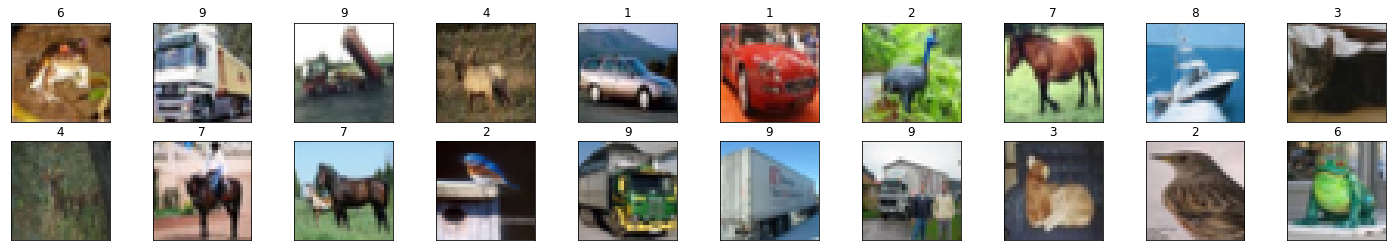

In [28]:
visualize(cifar_data_train)

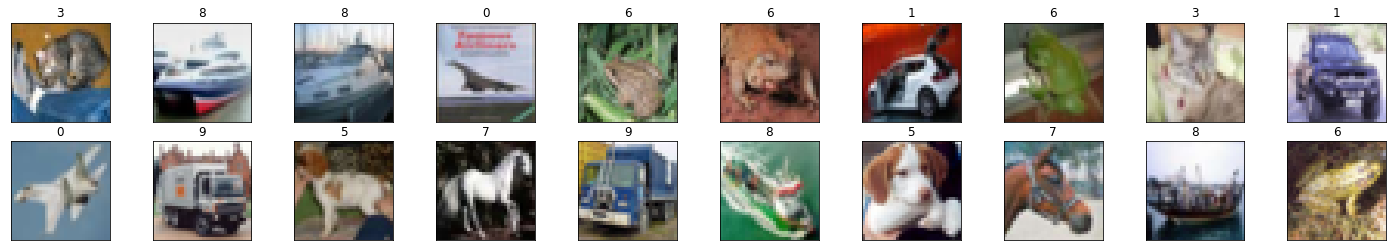

In [29]:
visualize(cifar_data_test)

## Partitioning the Data (IID and non-IID)

In [30]:
def iid_partition(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset containing the CIFAR Images
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

In [31]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Each of the clients will get X shards

  params:
    - dataset (torch.utils.Dataset): Dataset containing the CIFAR Images
    - clients (int): Number of Clients to split the data between
    - total_shards (int): Number of shards to partition the data in
    - shards_size (int): Size of each shard 
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives

  returns:
    - Dictionary of image indexes for each client
  """
  
  shard_idxs = [i for i in range(total_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
  idxs = np.arange(len(dataset))
  data_labels = np.array(dataset.targets)

  # sort the labels
  label_idxs = np.vstack((idxs, data_labels))
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  idxs = label_idxs[0,:]

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(clients):
    rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    shard_idxs = list(set(shard_idxs) - rand_set)

    for rand in rand_set:
      client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
  
  return client_dict





##Models

In [32]:
class CIFAR_MLP(nn.Module):
  def __init__(self):
    super(CIFAR_MLP, self).__init__()
    self.fc1 = nn.Linear(3 * 32 * 32, 2634)
    self.fc2 = nn.Linear(2634, 2196) 
    self.fc3 = nn.Linear(2196, 1758)
    self.fc4 = nn.Linear(1758, 1320)
    self.fc5 = nn.Linear(1320, 882)
    self.fc6 = nn.Linear(882, 444) 
    self.fc7 = nn.Linear(444, 10) 

  def forward(self, x):
    x = x.view(-1, 3 * 32 * 32)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = F.relu(self.fc5(x))
    x = F.relu(self.fc6(x))

    x = self.fc7(x)
    return x

In [33]:
class CIFAR_CNN(nn.Module):
  def __init__(self):
    super(CIFAR_CNN, self).__init__()

    self.conv_layer = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=0.05),

      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
    )

    self.fc_layer = nn.Sequential(
      nn.Dropout(p=0.1),
      nn.Linear(4096, 1024),
      nn.ReLU(inplace=True),
      nn.Linear(1024, 512),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.1),
      nn.Linear(512, 10)
    )


  def forward(self, x):      
    # conv layers
    x = self.conv_layer(x)
    
    # flatten
    x = x.view(x.size(0), -1)
    
    # fc layer
    x = self.fc_layer(x)

    return x

### Print Model Summaries

In [34]:
cifar_mlp = CIFAR_MLP()
cifar_cnn = CIFAR_CNN()

if torch.cuda.is_available():
  cifar_mlp.cuda()
  cifar_cnn.cuda()

print("CIFAR MLP SUMMARY")
print(summary(cifar_mlp, (32,32,3)))

print("\nCIFAR CNN SUMMARY")
print(summary(cifar_cnn, (3, 32,32)))

CIFAR MLP SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2634]       8,094,282
            Linear-2                 [-1, 2196]       5,786,460
            Linear-3                 [-1, 1758]       3,862,326
            Linear-4                 [-1, 1320]       2,321,880
            Linear-5                  [-1, 882]       1,165,122
            Linear-6                  [-1, 444]         392,052
            Linear-7                   [-1, 10]           4,450
Total params: 21,626,572
Trainable params: 21,626,572
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 82.50
Estimated Total Size (MB): 82.58
----------------------------------------------------------------
None

CIFAR CNN SUMMARY
--------------------------------------------------------

## q Federated Averaging

### Local Training (Client Update)

Local training for the model on client side

In [35]:
class CustomDataset(Dataset):
  def __init__(self, dataset, idxs):
      self.dataset = dataset
      self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, item):
      image, label = self.dataset[self.idxs[item]]
      return image, label


class ClientUpdate(object):
  def __init__(self, dataset, batch_size, learning_rate, epochs, idxs, q=None):
    if hasattr(dataset, 'dataloader'):
        self.train_loader = dataset.dataloader(batch_size=batch_size, shuffle=True)
    else:
        self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batch_size, shuffle=True)

    self.learning_rate = learning_rate
    self.epochs = epochs
    self.q = q
    if not self.q:
        # TODO: Client itself adjust fairness 
        pass
    self.mu = 1e-10

  def train(self, model):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)

    e_loss = []

    model_weights = copy.deepcopy(model.state_dict())
    for epoch in range(1, self.epochs+1):

      train_loss = 0.0

      model.train()
      # for data, labels in tqdm(self.train_loader):
      for data, labels in self.train_loader:

        if torch.cuda.is_available():
          data, labels = data.cuda(), labels.cuda()

        # clear the gradients
        optimizer.zero_grad()
        # make a forward pass
        output = model(data)
        # calculate the loss
        loss = criterion(output, labels)
        # do a backwards pass
        loss.backward()
        # perform a single optimization step
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

      # average losses
      train_loss = train_loss/len(self.train_loader.dataset)
      e_loss.append(train_loss)


    total_loss = sum(e_loss)/len(e_loss)

    # delta weights
    model_weights_new = copy.deepcopy(model.state_dict())
    L = 1.0 / self.learning_rate

    delta_weights, delta, h = {}, {}, {}
    loss_q = np.float_power(total_loss + self.mu, self.q)
    # updating the global weights
    for k in model_weights_new.keys():
      delta_weights[k] = (model_weights[k] - model_weights_new[k]) * L
      delta[k] =  loss_q * delta_weights[k]
      # Estimation of the local Lipchitz constant
      h[k] = (self.q * np.float_power(total_loss + self.mu, self.q - 1) * torch.pow(torch.norm(delta_weights[k]), 2)) + (L * loss_q)

    return delta, h, total_loss

### Server Side Training

Following Algorithm 1 from the paper

In [36]:
def client_sampling(n, m, weights=None, with_replace=False):
    pk = None
    if weights:
        total_weights = np.sum(np.asarray(weights))
        pk = [w * 1.0 / total_weights for w in weights]

    return np.random.choice(range(n), m, replace=with_replace, p=pk)

In [37]:
def training(model, rounds, batch_size, lr, ds, ds_test, data_dict, C, K, E, q, sampling, plt_title, plt_color):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - ds_test:         Dataset used for testing
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - tb_writer_name:  Directory name to save the tensorboard logs
  Returns:
    - model:           Trained model on the server
  """

  # global model weights
  global_weights = model.state_dict()

  # training loss
  # train_accuracy = []
  train_loss = []
  test_accuracy = []
  test_loss = []
  f1_macro = []
  f1_weighted = []

  # client weights by total samples
  p_k = None
  if sampling == 'weighted':
    p_k = [len(data_dict[c]) for c in data_dict] if ds else [len(data_dict[c]['train_ds']) for c in data_dict]

  # Time log
  start_time = time.time()

  users_id = list(data_dict.keys())

  for curr_round in range(1, rounds+1):
    deltas, hs, local_loss = [], [], []

    m = max(int(C*K), 1)    
    S_t = client_sampling(K, m, weights=p_k, with_replace=False)

    print('Round: {} Picking {}/{} clients: {}'.format(curr_round, m, K, S_t))

    global_weights = model.state_dict()

    for k in range(len(S_t)):
      key = users_id[k]
      ds_ = ds if ds else data_dict[key]['train_ds']
      idxs = data_dict[key] if ds else None
      local_update = ClientUpdate(dataset=ds_, batch_size=batch_size, learning_rate=lr, epochs=E, idxs=idxs, q=q)
      delta_k, h_k, loss = local_update.train(model=copy.deepcopy(model))

      deltas.append(copy.deepcopy(delta_k))
      hs.append(copy.deepcopy(h_k))
      local_loss.append(copy.deepcopy(loss))

    # Perform qFedAvg
    h_sum = copy.deepcopy(hs[0])
    delta_sum = copy.deepcopy(deltas[0])
    
    for k in h_sum.keys():
        for i in range(1, len(hs)):
            h_sum[k] += hs[i][k]
            delta_sum[k] += deltas[i][k]

    new_weights = {}
    for k in delta_sum.keys():
        for i in range(len(deltas)):
            new_weights[k] = delta_sum[k] / h_sum[k]

    # Updating global model weights
    for k in global_weights.keys():
        if 'num_batches_tracked' in k:
            continue
        global_weights[k] -= new_weights[k]

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)))
    train_loss.append(loss_avg)

    # test
    test_criterion = nn.CrossEntropyLoss()
    test_accuracy_current, test_loss_current, f1_macro_current, f1_weighted_current =  testing(copy.deepcopy(model), ds_test, 128, test_criterion, num_classes, classes_test)
    test_accuracy.append(test_accuracy_current)
    test_loss.append(test_loss_current)
    f1_macro.append(f1_macro_current)
    f1_weighted.append(f1_weighted_current)

  end_time = time.time()
  
  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(train_loss)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Train Loss',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_Train_loss.jpg', format='jpg')
  plt.show()

  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(test_loss)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Test Loss',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_Test_loss.jpg', format='jpg')
  plt.show()

  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(test_accuracy)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Test Accuracy',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_Test_Accuracy.jpg', format='jpg')
  plt.show()

  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(f1_macro)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='F1 Macro',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_F1_Marco.jpg', format='jpg')
  plt.show()

  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(f1_weighted)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='F1 Weighted',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_F1_Weighted.jpg', format='jpg')
  plt.show()

  print("Training Done!")
  print("Total time taken to Train: {}\n\n".format(end_time-start_time))
  
  return model, train_loss, test_accuracy, test_loss, f1_macro, f1_weighted

## Testing Loop

In [38]:
def testing(model, dataset, bs, criterion, num_classes, classes, print_info=False):
  #test loss 
  test_loss = 0.0
  y_true, y_hat = None, None

  correct_class = list(0 for i in range(num_classes))
  total_class = list(0 for i in range(num_classes))

  if hasattr(dataset, 'dataloader'):
    test_loader = dataset.dataloader(batch_size=bs, shuffle=False)
  else:
    test_loader = DataLoader(dataset, batch_size=bs, shuffle=False)

  l = len(test_loader)

  model.eval()
  for i, (data, labels) in enumerate(test_loader):

    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

    output = model(data)
    loss = criterion(output, labels)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, dim=1)

    # For F1Score
    y_true = np.append(y_true, labels.data.view_as(pred).cpu().numpy()) if i != 0 else labels.data.view_as(pred).cpu().numpy()
    y_hat = np.append(y_hat, pred.cpu().numpy()) if i != 0 else pred.cpu().numpy()

    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    for i, lbl in enumerate(labels.data):
      try:
        correct_class[lbl.item()] += correct[i]
        total_class[lbl.item()] += 1
      except:
          print('Error', lbl, i)
    
  # avg test loss
  test_loss = test_loss/len(test_loader.dataset)
  test_accuracy = 100. * np.sum(correct_class) / np.sum(total_class)
  # Avg F1 Score
  f1_macro = f1_score(y_true, y_hat, average='macro')
  # F1-Score -> weigthed to consider class imbalance
  f1_weighted =  f1_score(y_true, y_hat, average='weighted')

  if print_info:
    print("Test Loss: {:.6f}\n".format(test_loss))

    for i in range(10):
      if total_class[i]>0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % 
              (classes[i], 100 * correct_class[i] / total_class[i],
              np.sum(correct_class[i]), np.sum(total_class[i])))
      else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nFinal Test  Accuracy: {:.3f} ({}/{})'.format(
          100. * np.sum(correct_class) / np.sum(total_class),
          np.sum(correct_class), np.sum(total_class)))

    print("F1 Score: {:.6f} (macro) {:.6f} (weighted) %\n".format(f1_macro, f1_weighted))
  
  return test_accuracy, test_loss, f1_macro, f1_weighted

## Logger

In [39]:
log_dict = {}
NUM_REPEAT = 5

## CIFAR CNN on IID

### Train


Experiment Run Number:  0
Round: 1 Picking 10/100 clients: [62 95 33 39  3 35 97 42 19 85]
Round: 1... 	Average Loss: 2.126
Round: 2 Picking 10/100 clients: [70 49 71 94  4 68 92 99 53 13]
Round: 2... 	Average Loss: 1.996
Round: 3 Picking 10/100 clients: [ 2 76 26 31 72 85 49 83 71 51]
Round: 3... 	Average Loss: 1.879
Round: 4 Picking 10/100 clients: [19 66 82 87 24 40  8 70 59 42]
Round: 4... 	Average Loss: 1.787
Round: 5 Picking 10/100 clients: [28 35 13 53 14  8 23 25 85 33]
Round: 5... 	Average Loss: 1.691
Round: 6 Picking 10/100 clients: [81 68 48  7 71 47 23 74 25 56]
Round: 6... 	Average Loss: 1.612
Round: 7 Picking 10/100 clients: [51 91 76 16 18 39 63 85  4 31]
Round: 7... 	Average Loss: 1.544
Round: 8 Picking 10/100 clients: [76 51 60 84 44 53 30 85 71 15]
Round: 8... 	Average Loss: 1.475
Round: 9 Picking 10/100 clients: [17 23  7 78 87 22 51  0 89 52]
Round: 9... 	Average Loss: 1.411
Round: 10 Picking 10/100 clients: [89 43 73 14  6 98  9 21 64 69]
Round: 10... 	Average Loss

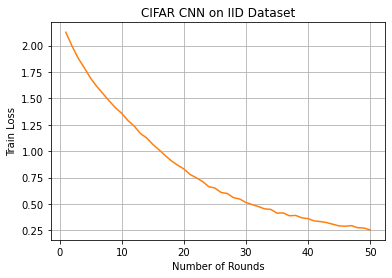

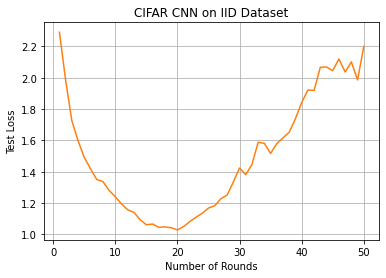

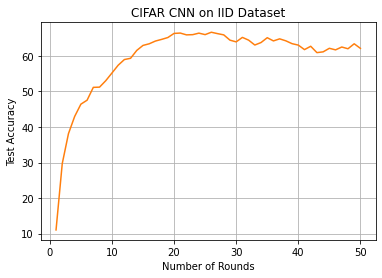

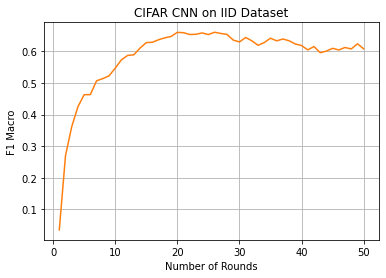

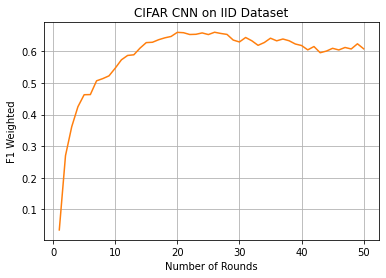

Training Done!
Total time taken to Train: 2841.180505990982


Experiment Run Number:  1
Round: 1 Picking 10/100 clients: [74  9 34 84 81 45 94 43 13  8]
Round: 1... 	Average Loss: 2.124
Round: 2 Picking 10/100 clients: [11  8 99 27 46 54 73 60 53 17]
Round: 2... 	Average Loss: 2.002
Round: 3 Picking 10/100 clients: [15 71 99 52 45 69 46 79 57 81]
Round: 3... 	Average Loss: 1.892
Round: 4 Picking 10/100 clients: [70 46  6 32 43  7 45 87 12 36]
Round: 4... 	Average Loss: 1.797
Round: 5 Picking 10/100 clients: [98 65 66  9 34  8 38 39 47 30]
Round: 5... 	Average Loss: 1.715
Round: 6 Picking 10/100 clients: [21 31 75 59 93 76 84 87 55 79]
Round: 6... 	Average Loss: 1.642
Round: 7 Picking 10/100 clients: [65 41 46 52 25  7 71 49 98 44]
Round: 7... 	Average Loss: 1.563
Round: 8 Picking 10/100 clients: [34 23 22  6 28 82  5 74 87 59]
Round: 8... 	Average Loss: 1.493
Round: 9 Picking 10/100 clients: [69 42 94 46  6  9  1 92 96 99]
Round: 9... 	Average Loss: 1.434
Round: 10 Picking 10/100 clien

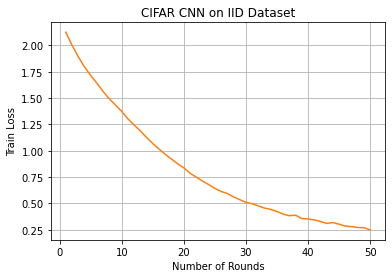

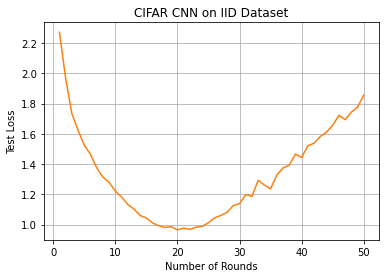

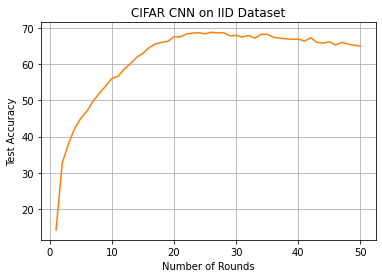

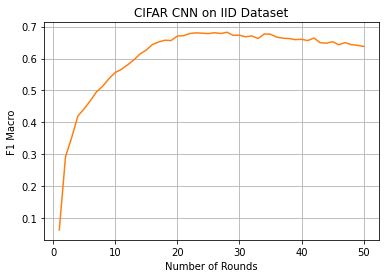

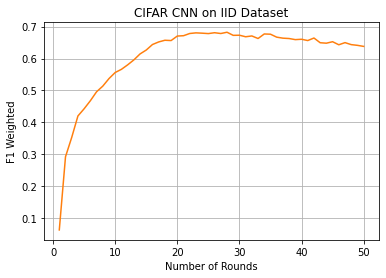

Training Done!
Total time taken to Train: 2841.741713285446


Experiment Run Number:  2
Round: 1 Picking 10/100 clients: [69 95 84  6  5 49 26 22 81 46]
Round: 1... 	Average Loss: 2.124
Round: 2 Picking 10/100 clients: [79 14 41 29  4 57 19 98 28 81]
Round: 2... 	Average Loss: 1.996
Round: 3 Picking 10/100 clients: [25 66 11 12 41  0 58 70 79 36]
Round: 3... 	Average Loss: 1.893
Round: 4 Picking 10/100 clients: [ 5 35  8 72  0 14 47 80 34 81]
Round: 4... 	Average Loss: 1.803
Round: 5 Picking 10/100 clients: [80 30 93 20 35 66 44 88 37 19]
Round: 5... 	Average Loss: 1.726
Round: 6 Picking 10/100 clients: [13 21 85 82 33 28 17 90 60 72]
Round: 6... 	Average Loss: 1.648
Round: 7 Picking 10/100 clients: [32 27 41 49 92 26 58 43  0 78]
Round: 7... 	Average Loss: 1.588
Round: 8 Picking 10/100 clients: [15 52 50 29 23 75 87 67 32 57]
Round: 8... 	Average Loss: 1.506
Round: 9 Picking 10/100 clients: [68 36 75 80  7 89 37  2  9 12]
Round: 9... 	Average Loss: 1.445
Round: 10 Picking 10/100 clien

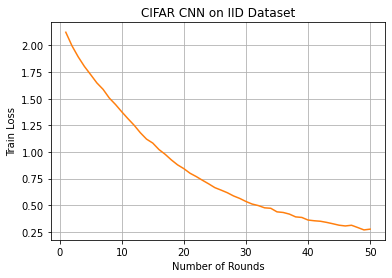

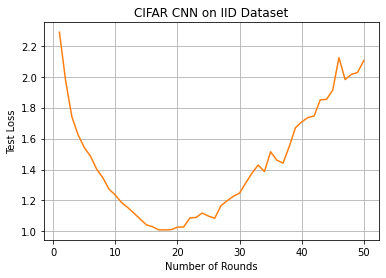

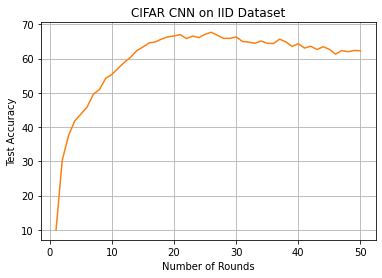

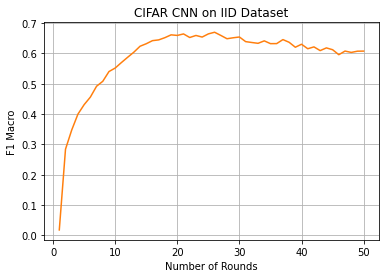

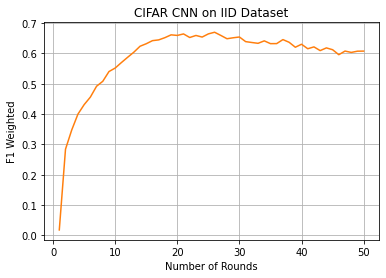

Training Done!
Total time taken to Train: 2843.575721502304


Experiment Run Number:  3
Round: 1 Picking 10/100 clients: [91 50 11 25 99 49 40 57 74 12]
Round: 1... 	Average Loss: 2.137
Round: 2 Picking 10/100 clients: [75 56  3 65 98 72 61 20 46  1]
Round: 2... 	Average Loss: 2.013
Round: 3 Picking 10/100 clients: [58 88 44 32 73 43 25  9 31 49]
Round: 3... 	Average Loss: 1.909
Round: 4 Picking 10/100 clients: [48 15 64 71 93 21 45 98 46 81]
Round: 4... 	Average Loss: 1.822
Round: 5 Picking 10/100 clients: [90 93 17 73 71 70  9  8 68  2]
Round: 5... 	Average Loss: 1.737
Round: 6 Picking 10/100 clients: [13 35 40 51 65 14 95 53 99 17]
Round: 6... 	Average Loss: 1.656
Round: 7 Picking 10/100 clients: [58 34 29 22 78 52 56 76 81 38]
Round: 7... 	Average Loss: 1.575
Round: 8 Picking 10/100 clients: [90 30 31 52 89 54 28 76 33 68]
Round: 8... 	Average Loss: 1.492
Round: 9 Picking 10/100 clients: [92 38 76 66 68 34 57 33 84 49]
Round: 9... 	Average Loss: 1.421
Round: 10 Picking 10/100 clien

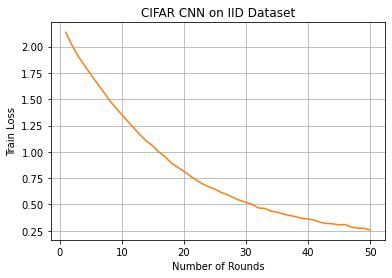

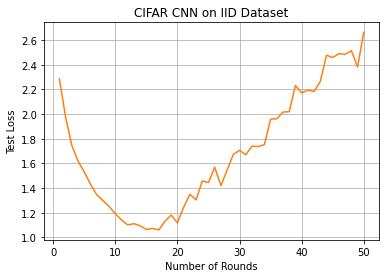

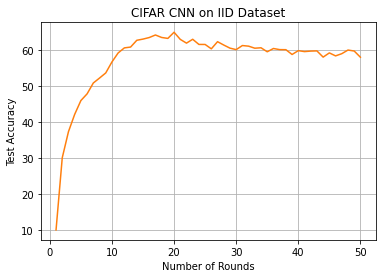

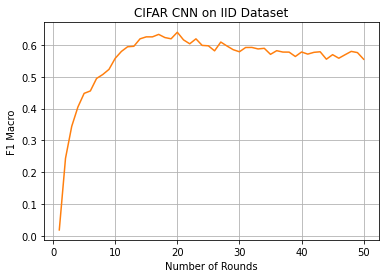

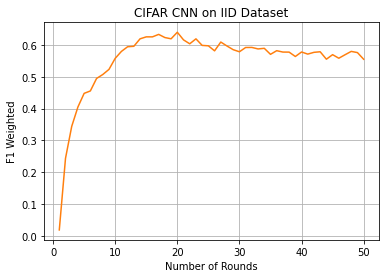

Training Done!
Total time taken to Train: 2842.5708508491516


Experiment Run Number:  4
Round: 1 Picking 10/100 clients: [33 38 28 62 22 34 50 59  9 29]
Round: 1... 	Average Loss: 2.125
Round: 2 Picking 10/100 clients: [43 47 46 31  6 16 73 81 28 27]
Round: 2... 	Average Loss: 2.004
Round: 3 Picking 10/100 clients: [ 6 68 23 24 33 77 13 58 96 94]
Round: 3... 	Average Loss: 1.885
Round: 4 Picking 10/100 clients: [68 11 76 39 27  4  6 85 69 78]
Round: 4... 	Average Loss: 1.792
Round: 5 Picking 10/100 clients: [89 63 68 78 16 39 86 30 15 37]
Round: 5... 	Average Loss: 1.706
Round: 6 Picking 10/100 clients: [28 58 29 16 76 60 20 99  9 64]
Round: 6... 	Average Loss: 1.625
Round: 7 Picking 10/100 clients: [98 53 94 33  0 51 11 85 91 82]
Round: 7... 	Average Loss: 1.55
Round: 8 Picking 10/100 clients: [25 16 29 93  9 22  7 54 18 39]
Round: 8... 	Average Loss: 1.476
Round: 9 Picking 10/100 clients: [51 85 61 90  3 68 42 70 84 58]
Round: 9... 	Average Loss: 1.402
Round: 10 Picking 10/100 clien

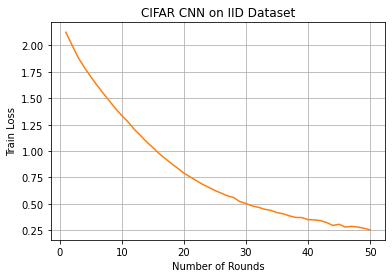

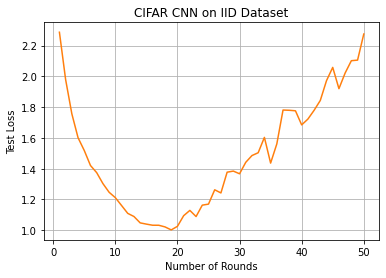

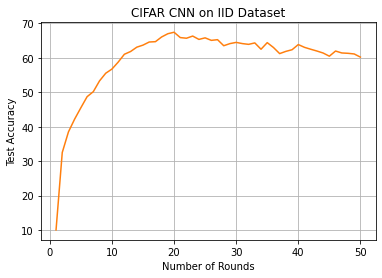

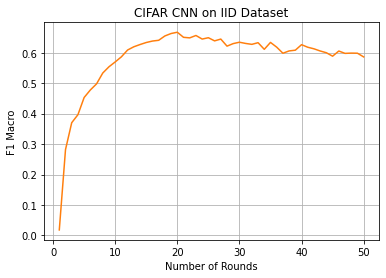

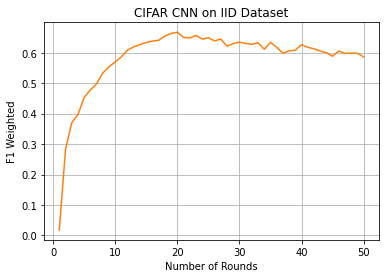

Training Done!
Total time taken to Train: 2842.4858491420746




In [40]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT
f1_macro_multiple_runs = [None] * NUM_REPEAT
f1_weighted_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)

  # number of training rounds
  rounds = 50
  # client fraction
  C = 0.1
  # number of clients
  K = 100
  # number of training passes on local dataset for each roung
  E = 5
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.05
  # fairness
  q = 0.001
  # sampling
  # sampling = 'uniform'
  sampling = 'weighted'
  
  # data partition dictionary
  iid_dict = iid_partition(cifar_data_train, 100)
  # load model
  cifar_cnn = CIFAR_CNN()

  if torch.cuda.is_available():
    cifar_cnn.cuda()

  cifar_cnn_iid_trained, train_loss, test_accuracy, test_loss, f1_macro, f1_weighted = training(cifar_cnn, rounds, batch_size, lr, cifar_data_train, cifar_data_test, iid_dict, C, K, E, q, sampling, "CIFAR CNN on IID Dataset", "orange")

  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss
  f1_macro_multiple_runs[exp_num] = f1_macro
  f1_weighted_multiple_runs[exp_num] = f1_weighted
    
  del cifar_cnn_iid_trained
  torch.cuda.empty_cache()

### Test

In [41]:
criterion = nn.CrossEntropyLoss()
acc, loss, f1_macro, f1_weighted = testing(cifar_cnn_iid_trained, cifar_data_test, 128, criterion, num_classes, classes_test, True)

In [42]:
hyperparams = {'rounds': rounds,
               'C': C,
               'K': K,
               'E': E,
               'batch_size': batch_size,
               'lr': lr,
               'q': q,
               'sampling': sampling
               }

log_dict['CIFAR CNN on IID'] = {'train_loss': train_loss_multiple_runs, 
                                'test_loss': test_loss_multiple_runs, 
                                'test_accuracy': test_accuracy_multiple_runs,
                                'f1_macro': f1_macro_multiple_runs,
                                'f1_weighted': f1_weighted_multiple_runs,
                                'hyperparams': hyperparams,
                                }

## CIFAR CNN on Non IID

### Train


Experiment Run Number:  0
Round: 1 Picking 10/100 clients: [ 8 41 65 13 18 86 11 57  4 78]
Round: 1... 	Average Loss: 0.64
Round: 2 Picking 10/100 clients: [24 22 25 53 54 50 39  9 10 58]
Round: 2... 	Average Loss: 0.57
Round: 3 Picking 10/100 clients: [46 15 72 66 29 23 71 28 13 25]
Round: 3... 	Average Loss: 0.479
Round: 4 Picking 10/100 clients: [46 26 61 50 66 65 76 56 60 25]
Round: 4... 	Average Loss: 0.434
Round: 5 Picking 10/100 clients: [19 67 81 38 41 96 11 16 85 37]
Round: 5... 	Average Loss: 0.396
Round: 6 Picking 10/100 clients: [96 73 90 50 55  6 59 38 16 20]
Round: 6... 	Average Loss: 0.379
Round: 7 Picking 10/100 clients: [17 54 82 42 92 21 38 23 35 56]
Round: 7... 	Average Loss: 0.359
Round: 8 Picking 10/100 clients: [34 14 15  5 44 22 19 76 48 97]
Round: 8... 	Average Loss: 0.332
Round: 9 Picking 10/100 clients: [23 76 68 60  2 99 58 34 82 33]
Round: 9... 	Average Loss: 0.327
Round: 10 Picking 10/100 clients: [52 39 92 11 64 51 88  7 54 49]
Round: 10... 	Average Loss: 

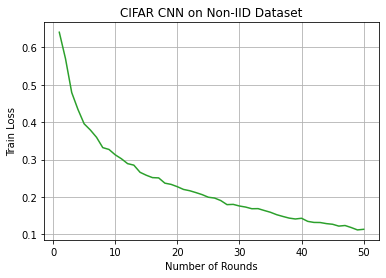

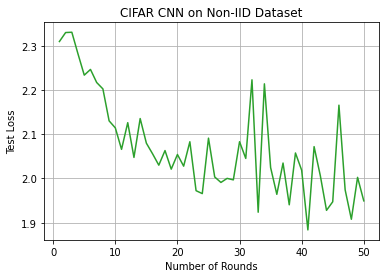

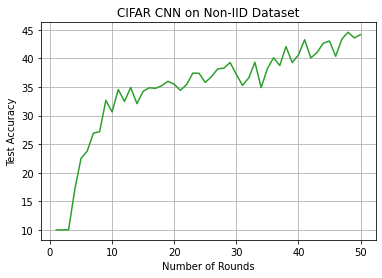

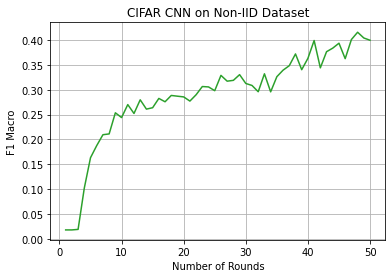

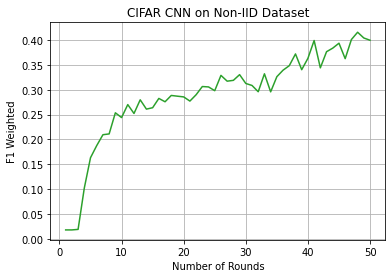

Training Done!
Total time taken to Train: 2834.9272475242615


Experiment Run Number:  1
Round: 1 Picking 10/100 clients: [73 44 67 41  7 85 74 75 69 66]
Round: 1... 	Average Loss: 0.662
Round: 2 Picking 10/100 clients: [80 22 14 76 87 16 90 94 26 57]
Round: 2... 	Average Loss: 0.568
Round: 3 Picking 10/100 clients: [40 14  6 77 89 73 63 85 54 31]
Round: 3... 	Average Loss: 0.491
Round: 4 Picking 10/100 clients: [12  1 92 88  9 70 37 20 15 89]
Round: 4... 	Average Loss: 0.439
Round: 5 Picking 10/100 clients: [62 66 67 18 84 78 13 43 80 10]
Round: 5... 	Average Loss: 0.405
Round: 6 Picking 10/100 clients: [80 44 67  9 49 89 11 41 15  2]
Round: 6... 	Average Loss: 0.376
Round: 7 Picking 10/100 clients: [99 28 85 17 12 29 39 64 42 19]
Round: 7... 	Average Loss: 0.341
Round: 8 Picking 10/100 clients: [82 69 86 24 71 11  0 46 91 36]
Round: 8... 	Average Loss: 0.318
Round: 9 Picking 10/100 clients: [ 2 41 74 34 36 10 79 73 43 95]
Round: 9... 	Average Loss: 0.294
Round: 10 Picking 10/100 clie

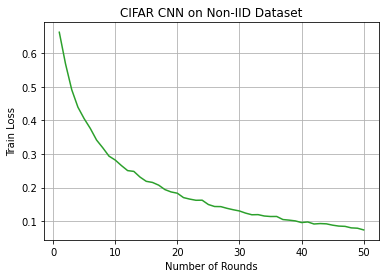

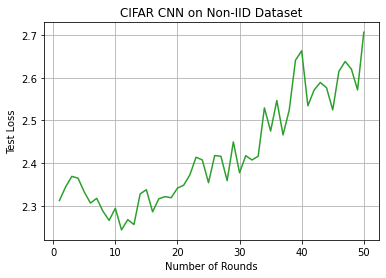

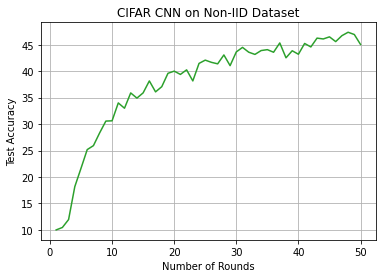

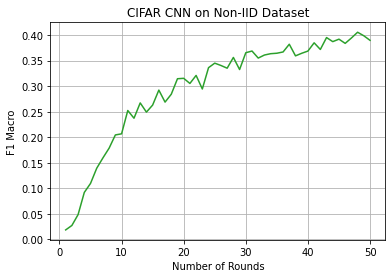

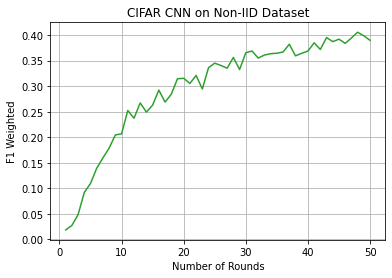

Training Done!
Total time taken to Train: 2836.447508096695


Experiment Run Number:  2
Round: 1 Picking 10/100 clients: [49 64 73  1 20 52 87 47 89 40]
Round: 1... 	Average Loss: 0.499
Round: 2 Picking 10/100 clients: [73 54 14 89 53 13 11 46 55 93]
Round: 2... 	Average Loss: 0.455
Round: 3 Picking 10/100 clients: [ 4 49 84 37 39 86 12 21 69 47]
Round: 3... 	Average Loss: 0.433
Round: 4 Picking 10/100 clients: [11 10 72 87 68 89 44 53 22 60]
Round: 4... 	Average Loss: 0.411
Round: 5 Picking 10/100 clients: [ 2 34 59 40 92 19 95 49 36 14]
Round: 5... 	Average Loss: 0.387
Round: 6 Picking 10/100 clients: [85 84 47 24 90 73 34 60 15 81]
Round: 6... 	Average Loss: 0.361
Round: 7 Picking 10/100 clients: [47 33 62 28 48 95 22  4  2  5]
Round: 7... 	Average Loss: 0.343
Round: 8 Picking 10/100 clients: [54 83 61 55 22 53 75 42 26 88]
Round: 8... 	Average Loss: 0.326
Round: 9 Picking 10/100 clients: [60 48 69 41 56 34 84 42  3 50]
Round: 9... 	Average Loss: 0.324
Round: 10 Picking 10/100 clien

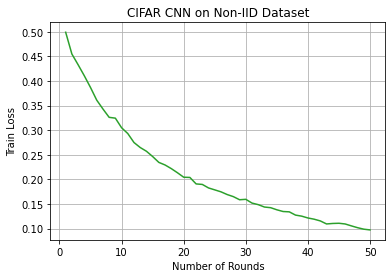

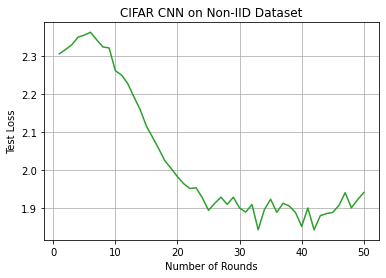

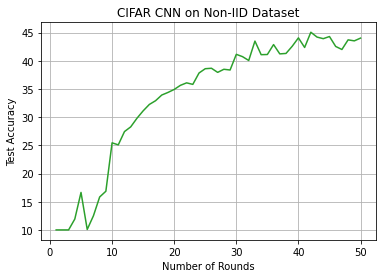

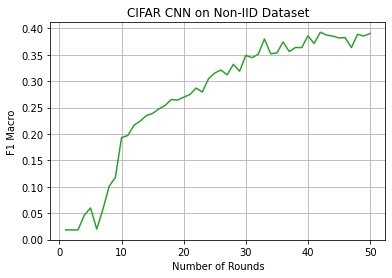

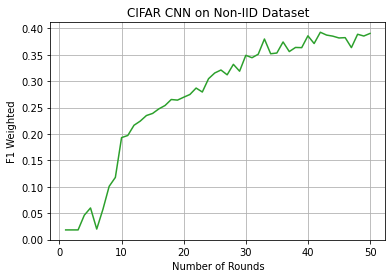

Training Done!
Total time taken to Train: 2838.520136833191


Experiment Run Number:  3
Round: 1 Picking 10/100 clients: [36 63  5 71 32 86 59 14 39 33]
Round: 1... 	Average Loss: 0.575
Round: 2 Picking 10/100 clients: [ 6 11 45 87 67 39 38 48 91 18]
Round: 2... 	Average Loss: 0.525
Round: 3 Picking 10/100 clients: [19 91 96 30  7 26 73 17 54 99]
Round: 3... 	Average Loss: 0.453
Round: 4 Picking 10/100 clients: [48 53 67 33 98 97  0 37 41 87]
Round: 4... 	Average Loss: 0.418
Round: 5 Picking 10/100 clients: [72 70 14 54  5 94 19 84 74 38]
Round: 5... 	Average Loss: 0.379
Round: 6 Picking 10/100 clients: [88 56 23  0 48 49 24 78 99 92]
Round: 6... 	Average Loss: 0.369
Round: 7 Picking 10/100 clients: [83 73 23 18 74 28 68 82  3 95]
Round: 7... 	Average Loss: 0.353
Round: 8 Picking 10/100 clients: [25 39 12 24 35 19 77 67 78 95]
Round: 8... 	Average Loss: 0.328
Round: 9 Picking 10/100 clients: [36 93 24 78 72  3 11 67 45 56]
Round: 9... 	Average Loss: 0.322
Round: 10 Picking 10/100 clien

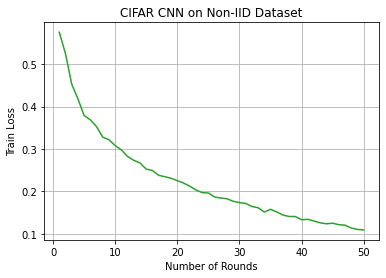

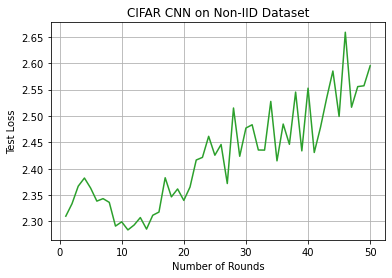

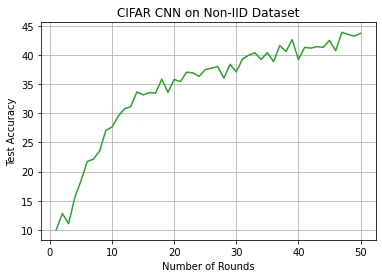

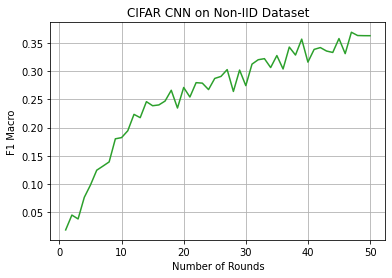

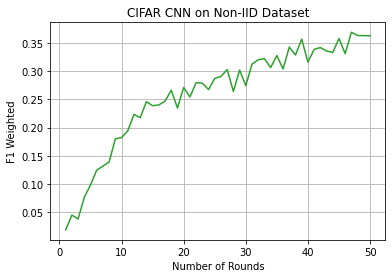

Training Done!
Total time taken to Train: 2838.6097304821014


Experiment Run Number:  4
Round: 1 Picking 10/100 clients: [48 93 87 70 52 86 41 89 68 40]
Round: 1... 	Average Loss: 0.643
Round: 2 Picking 10/100 clients: [79 99 97 47 83 80 51 40 77 17]
Round: 2... 	Average Loss: 0.565
Round: 3 Picking 10/100 clients: [93 41 32 74 31 27 92 43 23 86]
Round: 3... 	Average Loss: 0.525
Round: 4 Picking 10/100 clients: [60 20 52 33  6 39 87 64 13  1]
Round: 4... 	Average Loss: 0.46
Round: 5 Picking 10/100 clients: [77  7 32 16  0  1 44 84 73 66]
Round: 5... 	Average Loss: 0.425
Round: 6 Picking 10/100 clients: [51 49 41 19 79 10 77 99 35 50]
Round: 6... 	Average Loss: 0.4
Round: 7 Picking 10/100 clients: [15 12 18 29 98  9 41 94  2 63]
Round: 7... 	Average Loss: 0.373
Round: 8 Picking 10/100 clients: [65 11  7 67 74 82 70  5 12 45]
Round: 8... 	Average Loss: 0.35
Round: 9 Picking 10/100 clients: [36 42 11 63 41 26 52 82 58 30]
Round: 9... 	Average Loss: 0.328
Round: 10 Picking 10/100 clients:

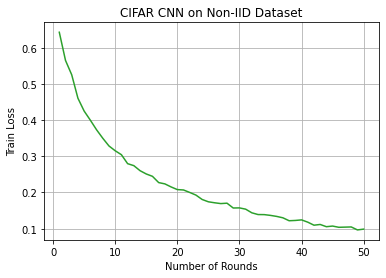

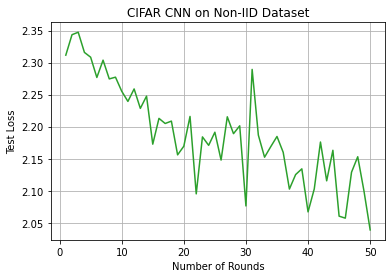

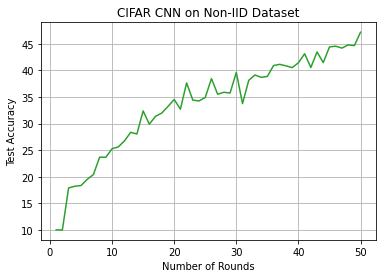

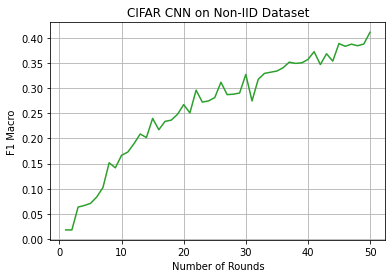

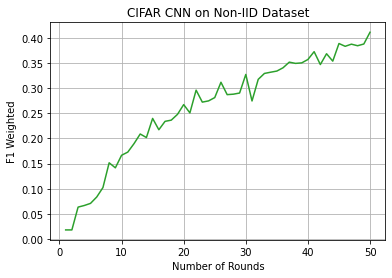

Training Done!
Total time taken to Train: 2836.803318977356




In [43]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT
f1_macro_multiple_runs = [None] * NUM_REPEAT
f1_weighted_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)

  # number of training rounds
  rounds = 50
  # client fraction
  C = 0.1
  # number of clients
  K = 100
  # number of training passes on local dataset for each roung
  E = 5
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.05
  # fairness
  q = 0.001
  # sampling
  # sampling = 'uniform'
  sampling = 'weighted'
  
  # dict containing different type of data partition
  data_dict = non_iid_partition(cifar_data_train, 100, 200, 250, 2)
  # load model
  cifar_cnn = CIFAR_CNN()

  if torch.cuda.is_available():
    cifar_cnn.cuda()
 
  cifar_cnn_non_iid_trained, train_loss, test_accuracy, test_loss, f1_macro, f1_weighted = training(cifar_cnn, rounds, batch_size, lr, cifar_data_train, cifar_data_test, data_dict, C, K, E, q, sampling, "CIFAR CNN on Non-IID Dataset", "green")

  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss
  f1_macro_multiple_runs[exp_num] = f1_macro
  f1_weighted_multiple_runs[exp_num] = f1_weighted

  del cifar_cnn_non_iid_trained
  torch.cuda.empty_cache()

### Test

In [44]:
criterion = nn.CrossEntropyLoss()
acc, loss, f1_macro, f1_weighted = testing(cifar_cnn_non_iid_trained, cifar_data_test, 128, criterion, num_classes, classes_test, True)

In [45]:
hyperparams = {'rounds': rounds,
               'C': C,
               'K': K,
               'E': E,
               'batch_size': batch_size,
               'lr': lr,
               'q': q,
               'sampling': sampling
               }

log_dict['CIFAR CNN on Non IID'] = {'train_loss': train_loss_multiple_runs, 
                                'test_loss': test_loss_multiple_runs, 
                                'test_accuracy': test_accuracy_multiple_runs,
                                'f1_macro': f1_macro_multiple_runs,
                                'f1_weighted': f1_weighted_multiple_runs,
                                'hyperparams': hyperparams,
                                }

## CIFAR MLP on IID

### Train

In [46]:
# train_loss_multiple_runs = [None] * NUM_REPEAT
# test_accuracy_multiple_runs = [None] * NUM_REPEAT
# test_loss_multiple_runs = [None] * NUM_REPEAT
# f1_macro_multiple_runs = [None] * NUM_REPEAT
# f1_weighted_multiple_runs = [None] * NUM_REPEAT

# for exp_num in range(NUM_REPEAT):
#   print("Experiment Run Number: ", exp_num)

#   # number of training rounds
#   rounds = 50
#   # client fraction
#   C = 0.1
#   # number of clients
#   K = 100
#   # number of training passes on local dataset for each round
#   E = 1
#   # batch size
#   batch_size = 10
#   # learning Rate
#   lr=0.05
#   # fairness
#   q = 0.001
#   # sampling
#   # sampling = 'uniform'
#   sampling = 'weighted'
  
#   # dict containing different type of data partition
#   data_dict = iid_partition(cifar_data_train, 100)
#   # load model
#   cifar_mlp = CIFAR_MLP()

#   if torch.cuda.is_available():
#     cifar_mlp.cuda()

#   cifar_mlp_iid_trained, train_loss, test_accuracy, test_loss, f1_macro, f1_weighted = training(cifar_mlp, rounds, batch_size, lr, cifar_data_train, cifar_data_test, data_dict, C, K, E, q, sampling, "CIFAR MLP on IID Dataset", "orange")
  
#   train_loss_multiple_runs[exp_num] = train_loss
#   test_accuracy_multiple_runs[exp_num] = test_accuracy
#   test_loss_multiple_runs[exp_num] = test_loss
#   f1_macro_multiple_runs[exp_num] = f1_macro
#   f1_weighted_multiple_runs[exp_num] = f1_weighted

#   del cifar_mlp_iid_trained
#   torch.cuda.empty_cache()

### Test

In [47]:
# criterion = nn.CrossEntropyLoss()
# acc, loss, f1_macro, f1_weighted = testing(cifar_mlp_iid_trained, cifar_data_test, 128, criterion, num_classes, classes_test, True)

In [48]:
# hyperparams = {'rounds': rounds,
#                'C': C,
#                'K': K,
#                'E': E,
#                'batch_size': batch_size,
#                'lr': lr,
#                'q': q,
#                'sampling': sampling
#                }

# log_dict['CIFAR MLP on IID'] = {'train_loss': train_loss_multiple_runs, 
#                                 'test_loss': test_loss_multiple_runs, 
#                                 'test_accuracy': test_accuracy_multiple_runs,
#                                 'f1_macro': f1_macro_multiple_runs,
#                                 'f1_weighted': f1_weighted_multiple_runs,
#                                 'hyperparams': hyperparams,
#                                 }

## CIFAR MLP on Non IID

### Train

In [49]:
# train_loss_multiple_runs = [None] * NUM_REPEAT
# test_accuracy_multiple_runs = [None] * NUM_REPEAT
# test_loss_multiple_runs = [None] * NUM_REPEAT
# f1_macro_multiple_runs = [None] * NUM_REPEAT
# f1_weighted_multiple_runs = [None] * NUM_REPEAT

# for exp_num in range(NUM_REPEAT):
#   print("Experiment Run Number: ", exp_num)
  
#   # number of training rounds
#   rounds = 50
#   # client fraction
#   C = 0.1
#   # number of clients
#   K = 100
#   # number of training passes on local dataset for each roung
#   E = 1
#   # batch size
#   batch_size = 10
#   # learning Rate
#   lr=0.05
#   # fairness
#   q = 0.001
#   # sampling
#   # sampling = 'uniform'
#   sampling = 'weighted'
  
#   # dict containing different type of data partition
#   data_dict = non_iid_partition(cifar_data_train, 100, 200, 250, 2)
#   # load model
#   cifar_mlp = CIFAR_MLP()

#   if torch.cuda.is_available():
#     cifar_mlp.cuda()

#   cifar_mlp_non_iid_trained, train_loss, test_accuracy, test_loss, f1_macro, f1_weighted = training(cifar_mlp, rounds, batch_size, lr, cifar_data_train, cifar_data_test, data_dict, C, K, E, q, sampling, "CIFAR MLP on Non-IID Dataset", "green")

#   train_loss_multiple_runs[exp_num] = train_loss
#   test_accuracy_multiple_runs[exp_num] = test_accuracy
#   test_loss_multiple_runs[exp_num] = test_loss
#   f1_macro_multiple_runs[exp_num] = f1_macro
#   f1_weighted_multiple_runs[exp_num] = f1_weighted
    
#   del cifar_mlp_non_iid_trained
#   torch.cuda.empty_cache()

### Test

In [50]:
# criterion = nn.CrossEntropyLoss()
# acc, loss, f1_macro, f1_weighted = testing(cifar_mlp_non_iid_trained, cifar_data_test, 128, criterion, num_classes, classes_test, True)

In [51]:
# hyperparams = {'rounds': rounds,
#                'C': C,
#                'K': K,
#                'E': E,
#                'batch_size': batch_size,
#                'lr': lr,
#                'q': q,
#                'sampling': sampling
#                }

# log_dict['CIFAR MLP on Non IID'] = {'train_loss': train_loss_multiple_runs, 
#                                 'test_loss': test_loss_multiple_runs, 
#                                 'test_accuracy': test_accuracy_multiple_runs,
#                                 'f1_macro': f1_macro_multiple_runs,
#                                 'f1_weighted': f1_weighted_multiple_runs,
#                                 'hyperparams': hyperparams,
#                                 }

## Pickle Log

In [52]:
import pickle

with open(path + 'Local_Round_qFedAvg.pkl', 'wb') as file:
  pickle.dump(log_dict, file)

In [53]:
log_dict

{'CIFAR CNN on IID': {'f1_macro': [[0.03531975903662508,
    0.27018426730528294,
    0.3612941616682536,
    0.4245896200861384,
    0.4624707730580594,
    0.46294334506410734,
    0.5064237626440509,
    0.5133937149887168,
    0.5221126032917125,
    0.5462970022221916,
    0.5727737200184776,
    0.5865970323911656,
    0.5886599770210468,
    0.6098272897758739,
    0.6271698487318369,
    0.6282616705299887,
    0.6363570878528746,
    0.6422913152445332,
    0.646615407800174,
    0.6595867048222446,
    0.6584576146128073,
    0.6527922064953529,
    0.6534487000227117,
    0.6577825520560224,
    0.6525984207026033,
    0.6599196098020672,
    0.6560907898078483,
    0.6530457703916432,
    0.6352339191413663,
    0.6292134372894689,
    0.6433219590235353,
    0.6328937399391213,
    0.618595556382074,
    0.6273526612752895,
    0.6411047454230424,
    0.6327989221979078,
    0.6385429682226937,
    0.6329971989890992,
    0.6227731754714639,
    0.6179679081762662,
    0.6

In [54]:
import pickle

with open(path + 'Local_Round_qFedAvg.pkl', 'rb') as file:
  log_dict = pickle.load(file)

In [55]:
print([test_acc[-1] for test_acc in log_dict['CIFAR CNN on IID']['test_accuracy']])

[62.14, 65.0, 62.28, 57.91, 60.22]


In [56]:
print([test_acc[-1] for test_acc in log_dict['CIFAR CNN on Non IID']['test_accuracy']])

[44.17, 45.05, 44.03, 43.68, 47.18]


In [57]:
# print([test_acc[-1] for test_acc in log_dict['CIFAR MLP on IID']['test_accuracy']])

In [58]:
# print([test_acc[-1] for test_acc in log_dict['CIFAR MLP on Non IID']['test_accuracy']])